# TP3 - exercice 1 : le BA-BA des SVMs

Dans cet exercice nous verrons comment apprendre un modèle SVM pour la classification à partir de la classe [**SVC**](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

Nous travaillerons toujours à partir du jeu de données **wine**, un jeu de données de classification mettant en jeu 3 catégories, dont on trouve un descriptif sur le [site de l'UCI](https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data).

Nous en profiterons pour revoir comment construire des "pipelines". 

## Question 1. Charger le jeu de données stocké dans le fichier *wine.csv*. La variable à prédire est contenue dans la colonne *wine*  grâce au code ci-dessous.
* Note : pour traiter un problème de classification multiclasse à $K$ catégories avec Scikit-Learn il est préférable de faire commencer les indices de classe à 0, i.e., de les encoder comme $0,1,...,K-1$.

In [1]:
# generic imports #
#-----------------#
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

load dataset of size 178 x 13 involving 3 classes
number of observation per categories :
[59 71 48]


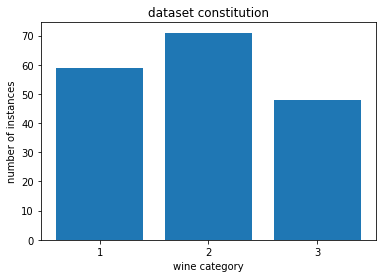

In [2]:
# get data using numpy #
#----------------------#
D = np.genfromtxt('wine.csv', delimiter = ',', skip_header = True)
# extract X and y
y = D[:,0]
X = D[:,1:]
# format y : make labels start at 0
y = y.astype('int')
class_ids = np.unique(y)
y-=1 

n = X.shape[0]
p = X.shape[1]
K = len(class_ids)
print('load dataset of size %d x %d involving %d classes' % (n,p,K))
print('number of observation per categories :')
print(np.bincount(y))

# show dataset constitution
counts = np.bincount(y)
plt.bar(range(K), counts)
plt.ylabel('number of instances')
plt.title('dataset constitution')
plt.xlabel('wine category')
plt.xticks(range(K), class_ids)
plt.show()

## Question 2. Le code  ci-dessous permet d'instancier un modèle SVM pour la classification, pour une valeur du paramètre $C=1$, et la stratégie *one-versus-rest* comme mode multi-classe. A quoi correpondent ces paramètres ? Quel noyau est utilisé par défaut ?

In [3]:
from sklearn.svm import SVC
svm_clf = SVC(C = 1, decision_function_shape = 'ovr')

## Question 3. Estimer les performances de ce modèle par validation croisée  et représenter les résultats sous la forme d'un boxplot.

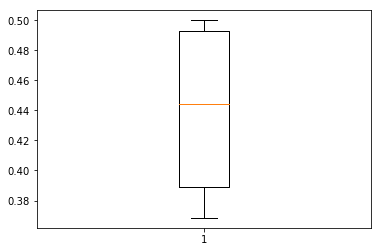

In [4]:
# estimate cross-validation performance of SVM by cross-valid
from sklearn.model_selection import cross_val_score
cv_perfs = cross_val_score(svm_clf, X, y, cv = 10)
plt.boxplot(cv_perfs)
plt.show()

## Question 3.Que fait la commande suivante ? Comment en déduit-on les résultats de classification ?

In [5]:
from sklearn.model_selection import cross_val_predict
cv_score = cross_val_predict(svm_clf, X, y, cv = 10, method = "decision_function")
cv_score[0:10,:]

array([[ 1.02257384,  2.23670077, -0.25927461],
       [ 1.05169275,  2.21993682, -0.27162957],
       [ 1.02232745,  2.23683524, -0.25916269],
       [ 1.0223165 ,  2.23684122, -0.25915771],
       [ 1.0223165 ,  2.23684122, -0.25915771],
       [ 1.0223165 ,  2.23684122, -0.25915771],
       [ 1.05220981,  2.14219967, -0.19440947],
       [ 1.01825827,  2.16090356, -0.17916183],
       [ 1.03804361,  2.15000378, -0.18804739],
       [ 1.02446956,  2.15747831, -0.18194787]])

## Question 4. Déduire la classe prédite à partir de la matrice *cv\_pred* calculée ci-dessus et interpéter les résultats grâce aux fonctions *classification_report* et *confusion_matrix* du module *metrics*.

In [6]:
# extract top class
cv_pred = np.argmax(cv_score, axis = 1)
cv_pred.shape

from sklearn.metrics import accuracy_score
print('*** global accuray ***')
print(accuracy_score(y, cv_pred))
from sklearn.metrics import classification_report
print('*** classification report ***')
print(classification_report(y, cv_pred))
from sklearn.metrics import confusion_matrix
print('*** confusion matrix ***')
print(confusion_matrix(y, cv_pred))

*** global accuray ***
0.438202247191
*** classification report ***
             precision    recall  f1-score   support

          0       0.80      0.07      0.12        59
          1       0.41      0.99      0.58        71
          2       1.00      0.08      0.15        48

avg / total       0.70      0.44      0.32       178

*** confusion matrix ***
[[ 4 55  0]
 [ 1 70  0]
 [ 0 44  4]]


## Question 4. Optimiser les paramètre  du modèle par validation croisée en utilisant la classe *GridSearchCV*. On considéra des valeurs de $C$ comprises entre $10^{-3}$ et $10^3$ qu'on répartira de manière logarithmique (e.g., $10^{-3}$, $10^{-2}$, ..., $10^{2}$, $10^{3}$) et on considèrera les deux stragégies multiclasses (*ovr* et *ovo*). Avez-vous beaucoup amélioré les performances ?

In [7]:
# optimise parameters C = {0.001,....,1000} and two types of decision functions (one-vs-one and one-vs-rest) 
from sklearn.model_selection import GridSearchCV
param_grid = {
    'decision_function_shape': ['ovr','ovo'],
    'C': np.logspace(-3,3, num=10)
}
svm_clf = SVC()
grid_search = GridSearchCV(svm_clf, param_grid, cv = 10)
grid_search.fit(X,y)

print("The best parameters are %s with a score of %0.2f"
     % (grid_search.best_params_, grid_search.best_score_))

The best parameters are {'C': 2.154434690031882, 'decision_function_shape': 'ovr'} with a score of 0.47


## Question 5. Reproduire cette analyse en considérant un "pipeline" d'analyse combinant (1) standardisation des descripteurs et (2) classification par SVM. Interpréter les résultats.
* on rappelle qu'on construit des "pipelines" en utilisant la classe **Pipeline** (du module **pipeline**).
* on rappelle également que la classe **StandardScaler** du module **preprocessing** permet de standardiser les descripteurs.

In [8]:
# do the same think using a pipeline integrating a prior step of feature standardization
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

param_grid_pipe = {
    'svm__decision_function_shape': ['ovr','ovo'],
    'svm__C': np.logspace(-3,3, num=10)
}

svm_clf = SVC()
grid_search_pipe = GridSearchCV(svm_pipe, param_grid_pipe, cv = 10)
grid_search_pipe.fit(X,y)

print("The best parameters are %s with a score of %0.2f"
     % (grid_search_pipe.best_params_, grid_search_pipe.best_score_))

The best parameters are {'svm__C': 0.46415888336127775, 'svm__decision_function_shape': 'ovr'} with a score of 0.98
